# COVID-19 Analysis and Prediction: A Modified SEIR infectious Model

## Table of Contents
<ul>
    <li><a href="#introduction">Introduction</a></li>
    <li><a href="#data_wrangling">Data Wrangling</a></li>
    <li><a href="#eda">Exploratory Data Analysis</a></li>
    <li><a href="#conclusion">Conclusions</a></li>
</ul>

<a id="introduction"></a>
## Introduction

The pandemics of COVID-19 in 2020 changed the life of everyone in the world. It is caused by a coronavirus called SARS-CoV-2. Different from most of other infectious disease, people who are infected with COVID-19 but do not exhibit symptoms can also spread the virus to others. Older adults and people who have severe underlying medical conditions like heart or lung disease or diabetes seem to be at higher risk for developing more serious complications from COVID-19 illness. As COVID-19 continues to spread across the country and the world, we should remain calm and take actions to slow down its spreading.

Here, we modified the SEIR model to accounts for the different infection feature of COVID-19 and the "lockdown" rules applied to most places. We studied three of the most serious countries: US, Italy, and France. This model fits the infection ratio and recover ratio very well.

I am keep working on this notebook and learning from the community. If you have any comments or questions, I'm happy to hear and answer.


<a id="data_wrangling"></a>
## Data wrangling
### Import packages

In [1]:
# Algebra
import numpy as np

# Dataframe
import pandas as pd

# Missing Analysis
import missingno as msno

# Modelling
from scipy import integrate
from scipy import optimize

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Map
import folium

# Datetime
from datetime import datetime

### Import datasets

Date source:
COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University ([GitHub link](https://github.com/CSSEGISandData/COVID-19))

In [2]:
# Global cases
global_confirm_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
global_death_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
global_recover_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
# US cases
us_confirm_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
us_death_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
us_state_loc_csv = 'https://gist.githubusercontent.com/mbostock/9535021/raw/eaed7e5632735a6609f02d0ba0e55c031e14200d/us-state-capitals.csv'

In [3]:
Confirmed = pd.read_csv(global_confirm_csv)
Death = pd.read_csv(global_death_csv) 
Recovered = pd.read_csv(global_recover_csv)
Confirmed_us = pd.read_csv(us_confirm_csv)
Death_us = pd.read_csv(us_death_csv)
us_state_location = pd.read_csv(us_state_loc_csv)

### Data cleaning

Settings to show the full dataset when print()

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

#### Global cases

remove unnecessary columns

In [5]:
# Global cases
Confirmed.drop(axis=1, inplace=True, columns=['Province/State', 'Lat', 'Long'])
Death.drop(axis=1, inplace=True, columns=['Province/State', 'Lat', 'Long'])
Recovered.drop(axis=1, inplace=True, columns=['Province/State', 'Lat', 'Long'])

In [6]:
display(Confirmed)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20
0,Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072,7653,8145,8676,9216,9998,10582,11173,11831,12456,13036,13659,14525,15205,15750,16509,17267,18054,18969,19551,20342,20917,21459,22142,22890,23546,24102,24766,25527,26310,26874,27532,27878,28424,28833,29157,29481,29640,30175,30451,30616,30967,31238,31517,31836,32022,32324,32672,32951,33190,33384,33594,33908,34194,34366,34451,34455,34740,34994,35070,35229,35301,35475,35526,35615,35727,35928,35981,36036,36157,36263,36368,36471,36542,36675,36710,36710,36747,36782,36829,36896,37015,37054,37054,37162,37269,37345,37424,37431,37551,37596,37599,37599,37599,37856,37894,37953,37999,38054,38070,38113,38129,38140,38143,38162,38165,38196,38243,38288,38304,38324,38398,38494,38520,38544,38572,38606,38641,38716,38772,38815,38855,38872,38883,38919,39044,39074,39096,39145,39170,39186,39192,39227,39233,39254,39268,39285,39290,39297,39341,39422,39486,39548,39616,39693,39703,39799,39870,39928,39994,40026,40073,40141,40200,40287,40357,40510,40626,40687,40768,40833,40937,41032,41145,41268,41334,41425,41501,41633,41728,41814,41935,41975,42033,42092,42297,42463,42609,42795,42969,43035,43240,43403,43628,43851,44228,44443,44503
1,Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [7]:
# function to extract the data of different cases in different country
def extract_national_data(df, country, case):
    df_extract = df[df['Country/Region'] == country].sum(axis=0)
    df_extract = df_extract.T.reset_index()
    df_extract = df_extract.iloc[1:]
    df_extract.columns = ['date', case]
    df_extract.date = pd.to_datetime(df_extract.date)
    return df_extract

In [8]:
# function to join three types of cases in one country
def join_national_data(confirmed, death, recovered):
    total_case = confirmed.join(death.set_index('date'), on='date').join(recovered.set_index('date'), on='date')
    total_case.reset_index(inplace=True, drop=True)
    return total_case

### US

In [9]:
us_confirmed = extract_national_data(Confirmed, 'US', 'positive')
us_death = extract_national_data(Death, 'US', 'death')
us_recovered = extract_national_data(Recovered, 'US', 'recovered')

In [10]:
us_status = join_national_data(us_confirmed, us_death, us_recovered)

In [25]:
us_test = us_status[:100]

In [11]:
us_status.head()

,date,positive,death,recovered
0,2020-01-22,1,0,0
1,2020-01-23,1,0,0
2,2020-01-24,2,0,0
3,2020-01-25,2,0,0
4,2020-01-26,5,0,0


### Italy

In [12]:
itl_confirmed = extract_national_data(Confirmed, 'Italy', 'positive')
itl_death = extract_national_data(Death, 'Italy', 'death')
itl_recovered = extract_national_data(Recovered, 'Italy', 'recovered')

In [13]:
itl_status = join_national_data(itl_confirmed, itl_death, itl_recovered)

In [14]:
itl_status.head()

,date,positive,death,recovered
0,2020-01-22,0,0,0
1,2020-01-23,0,0,0
2,2020-01-24,0,0,0
3,2020-01-25,0,0,0
4,2020-01-26,0,0,0


### France

In [15]:
frc_confirmed = extract_national_data(Confirmed, 'France', 'positive')
frc_death = extract_national_data(Death, 'France', 'death')
frc_recovered = extract_national_data(Recovered, 'France', 'recovered')

In [16]:
frc_status = join_national_data(frc_confirmed, frc_death, frc_recovered)

In [17]:
display(frc_status.head())

,date,positive,death,recovered
0,2020-01-22,0,0,0
1,2020-01-23,0,0,0
2,2020-01-24,2,0,0
3,2020-01-25,3,0,0
4,2020-01-26,3,0,0


<a id="eda"></a>
## Exploratory Data Analysis
## The modified SEIRS Model

Inspired by Kaike Wesley Reis's work on SEIR model in Kaggle community, I generated a modified SEIRS model for COVID-19.
More information about SEIRS model could be found [here.](https://www.idmod.org/docs/hiv/model-seir.html#:~:text=The%20SEIR%20model%20assumes%20people,return%20to%20a%20susceptible%20state)

In a closed population without births or deaths, the SEIRS model is:

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}S&space;}{\mathrm{d}&space;t}=&space;-\beta&space;SI&plus;\xi&space;R" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}S&space;}{\mathrm{d}&space;t}=&space;-\beta&space;SI&plus;\xi&space;R" title="\frac{\mathrm{d}S }{\mathrm{d} t}= -\beta SI+\xi R" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}E&space;}{\mathrm{d}&space;t}=\frac{\beta&space;SI}{N}-\sigma&space;E" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}E&space;}{\mathrm{d}&space;t}=\beta&space;SI-\sigma&space;E" title="\frac{\mathrm{d}E }{\mathrm{d} t}=\beta SI-\sigma E" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}I&space;}{\mathrm{d}&space;t}=\sigma&space;E-\gamma&space;I" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}I&space;}{\mathrm{d}&space;t}=\sigma&space;E-\gamma&space;I" title="\frac{\mathrm{d}I }{\mathrm{d} t}=\sigma E-\gamma I" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}R&space;}{\mathrm{d}&space;t}=&space;\gamma&space;I&space;-&space;\xi&space;R" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}R&space;}{\mathrm{d}&space;t}=&space;\gamma&space;I&space;-&space;\xi&space;R" title="\frac{\mathrm{d}R }{\mathrm{d} t}= \gamma I - \xi R" /></a>

Where S, E, I, R is the proportion of suceptible, exposed, infectious and recovered population.

In the case of COVID-19, the viral carriers ("exposed population) do not exhibit symptoms, yet are infectious. So, the SEIR model is modified as below:

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}S&space;}{\mathrm{d}&space;t}=&space;-\frac{\beta&space;S(I&plus;E)}{N}&plus;\xi&space;R" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}S&space;}{\mathrm{d}&space;t}=&space;-\beta&space;S(I&plus;E)&plus;\xi&space;R" title="\frac{\mathrm{d}S }{\mathrm{d} t}= -\frac{\beta S(I+E)}{N}+\xi R" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}E&space;}{\mathrm{d}&space;t}=\frac{\beta&space;S(I&plus;E)}{N}-\sigma&space;E" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}E&space;}{\mathrm{d}&space;t}=\beta&space;S(I&plus;E)-\sigma&space;E" title="\frac{\mathrm{d}E }{\mathrm{d} t}=\frac{\beta S(I+E)}{N}-\sigma E" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}I&space;}{\mathrm{d}&space;t}=\sigma&space;E-\gamma&space;I" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}I&space;}{\mathrm{d}&space;t}=\sigma&space;E-\gamma&space;I" title="\frac{\mathrm{d}I }{\mathrm{d} t}=\sigma E-\gamma I" /></a>


<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}R&space;}{\mathrm{d}&space;t}=&space;\gamma&space;I&space;-&space;\xi&space;R" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}R&space;}{\mathrm{d}&space;t}=&space;\gamma&space;I&space;-&space;\xi&space;R" title="\frac{\mathrm{d}R }{\mathrm{d} t}= \gamma I - \xi R" /></a>

Where S, E, I, R is the proportion of suceptible, exposed, infectious, and recovered population.

Here, we included the "exposed population" in the first and second formula, because it participates in the viral transmission.

Accordingly, we modified the functions as below:

In [18]:
# Function
def seir_model_ode(y, t, params): 
    '''
    Arguments:
    - y: dependent variables
    - t: independent variable (time)
    - params: Model parameters
    '''
    # Parameters to find
    infection_rate = params[0]
    recovery_rate = params[1]
    exposed_rate = params[2]
    reinfection_rate = params[3]
    
    # Y variables
    s = y[0]
    e = y[1]
    i = y[2]
    r = y[3]
    
    # SIR ODE System 
    dsdt = -exposed_rate*s*(i+e) + reinfection_rate*r
    dedt = (exposed_rate*s*(i+e)) - (infection_rate*e)
    didt = (infection_rate*e) - (recovery_rate*i)
    drdt = recovery_rate*i - reinfection_rate*r
    
    # Return our system
    return (dsdt, dedt, didt, drdt)

In [19]:
# FUNCTION - Calculate SEIR Model in t (time as days) based on given parameters
def calculate_seir_model(params, t, initial_condition):
    # Create an alias to our seir ode model to pass params to try
    seir_ode = lambda y,t:seir_model_ode(y,t, params)
    
    # Calculate ode solution, return values to each
    ode_result = integrate.odeint(func=seir_ode, y0=initial_condition, t=t)
    
    # Return results
    return ode_result

In [20]:
# FUNCTION - Auxiliar function to find the best parameters
def fit_seir_model(params_to_fit, t, initial_condition, i_r_true):
    # Calculate ODE solution for possible parameter, return values to each dependent variable:
    # (s, e, i and r)
    fit_result = calculate_seir_model(params_to_fit, t, initial_condition)
    
    # Calculate residual value between predicted VS true
    ## Note: ode_result[0] is S result
    residual_i = i_r_true[0] - fit_result[:,2]
    residual_r = i_r_true[1] - fit_result[:,3]
    
    # Create a np.array of all residual values for both (i) and (r)
    residual = np.concatenate((residual_i, residual_r))
    
    # Return results
    return residual

In [27]:
def countryLockdown(N, status,lockdownDay,countryName):
    
    """inputs:
    N: population in the country
    status: dataframe of the country
    lockdownDay: number of days since begining of data to the date of lockdown
    """
    
    # Define Initial Condition before lockdown
    I_start = status.loc[0, 'positive']/N
    E_start = (status.loc[14, 'positive'] - status.loc[0, 'positive'])/N
    S_start = 1 - E_start - I_start
    R_start = status.loc[0, 'recovered']/N
    
    # Set this values as a tuple of initial condition
    ic = (S_start, E_start, I_start, R_start)
    
    # Create a tuple with the true values in fraction for Infected/Recovered cases (necessary for error measurement)
    beforelockdown=status.loc[0:lockdownDay]
    afterlockdown=status.loc[lockdownDay+1:]
    i_r_true_bf = (list(beforelockdown['positive']/N), list(beforelockdown['recovered']/N))
    i_r_true_af = (list(afterlockdown['positive']/N), list(afterlockdown['recovered']/N))

    # Define a time array measure in days
    time_opt_bf = range(0, lockdownDay+1)
    time_opt_af = range(0, len(afterlockdown))
    time_opt =range(0,len(status))
    
    
    # define initial condition after lockdown
    E_start_day = min(len(status['date']),len(beforelockdown)+14)
    
    E_start_af = (status.loc[E_start_day, 'positive'] - status.loc[len(beforelockdown), 'positive'])/N
    I_start_af = status.loc[len(beforelockdown), 'positive']/N
    S_start_af = 1 - E_start_af - I_start_af
    R_start_af = status.loc[len(beforelockdown), 'recovered']/N
   
    # Set this values as a tuple
    ic_af = (S_start_af, E_start_af, I_start_af, R_start_af)
    
    # Define a start guess for our parameters [infection_rate, recovered rate]
    params_start_guess = [0.01, 0.001, 0.01, 0.001]
    optimal_params, success = optimize.leastsq(fit_seir_model,
                                          x0=params_start_guess,
                                          args=(time_opt_bf, ic, i_r_true_bf),
                                          ftol=1.49012e-22)
    optimal_params_af, success = optimize.leastsq(fit_seir_model,
                                          x0=params_start_guess,
                                          args=(time_opt_af, ic_af, i_r_true_af),
                                          ftol=1.49012e-22)
    
    print('## '+countryName+' before lockdown')
    print('Optimized infection rate: ', optimal_params[0])
    print('Optimized recovered rate: ', optimal_params[1])
    print('Optimized exposed rate: ', optimal_params[2])
    print('Optimized reinfection rate: ', optimal_params[3])
    print('\n')
    print('## '+countryName+' after lockdown')
    print('Optimize infection rate: ', optimal_params_af[0])
    print('Optimize recovered rate: ', optimal_params_af[1])
    print('Optimize exposed rate: ', optimal_params_af[2])
    print('Optimized reinfection rate: ', optimal_params_af[3])
            
            
    # Fit test
    ## Get the optimal parameters
    ir = optimal_params[0]
    rr = optimal_params[1]
    er = optimal_params[2]
    rir = optimal_params[3]
    ir_af = optimal_params_af[0]
    rr_af = optimal_params_af[1]
    er_af = optimal_params_af[2]
    rir_af = optimal_params_af[3]
    
    ## Calculate a curve based on those parameters
    fit_result_bf = calculate_seir_model((ir, rr, er, rir), time_opt_bf, ic)
    fit_result_af = calculate_seir_model((ir_af, rr_af, er_af, rir_af), time_opt_af, ic_af)

    ## Define plot object
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=[18, 5])
    fig.text(0.5, 0.04, 'Number of days after Jan-22nd 2020', ha='center', fontsize=12)
    ## Plot real and predicted infection
    ax1.set_title('Infected cases in '+ countryName,fontsize=20)
    ax1.plot(time_opt, i_r_true_bf[0]+i_r_true_af[0], 'ro', markersize = 0.3)
    ax1.plot(time_opt, np.hstack((fit_result_bf[:,2],fit_result_af[:,2])), 'co', markersize=0.3)
    ax1.legend(['Actual infection', 'Predicted infection'],loc=2, fontsize=12)
    ax1.set_ylabel('Proportion of population', fontsize=12)
    
    ## Plot real and predicted recover
    ax2.set_title('Recovered cases in '+countryName,fontsize=20)      
    ax2.plot(time_opt, i_r_true_bf[1]+i_r_true_af[1], 'ro', markersize = .3)
    ax2.plot(time_opt, np.hstack((fit_result_bf[:,3],fit_result_af[:,3])), 'go', markersize=0.3)
    ax2.legend(['Real recover', 'Predicted recover'],loc=2, fontsize=12)
    

    
    # Prediction
    ## Get prediction full period time in datetime object and the convert to string
    datetime_pred = pd.date_range(start="2020-02-01",end="2021-01-01", freq='D')
    pred_time = [x.strftime("%Y-%m-%d") for x in datetime_pred]
    pred_range = range(0, len(pred_time))
    pred_result = calculate_seir_model((ir_af, rr_af, er_af, rir_af), pred_range, ic_af)
    time_axis = [pred_time[i] for i in[0, 29, 60, 90, 121, 151, 182, 213, 243, 274, 304, 335]]
    time_labels = ['Feb.', 'Mar.', 'Apr.', 'May', 'June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.', 'Jan.']
    ## Plot SEIDR
    fig, ax = plt.subplots(figsize=[12,10])
    ax.plot(pred_time, pred_result[:,0],color='blue') #susceptible
    ax.plot(pred_time, pred_result[:,1],color='red') #exposed
    ax.plot(pred_time, pred_result[:,2],color='cyan') #infected
    ax.plot(pred_time, pred_result[:,3], color = 'black') #recovered
    ax.legend(loc=1, labels=['Susceptible', 'Exposed', 'Infected', 'Recovered'], fontsize=8)
    ax.set_title('SEIR predictions', fontsize=20)
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Proportion of population', fontsize=12)
    plt.xticks(time_axis, time_labels, rotation='vertical');

In [37]:
def countrynoLockdown(N, status,countryName):
    
    """inputs:
    N: population in the country
    status: dataframe of the country
    lockdownDay: number of days since begining of data to the date of lockdown
    """
    
    # Define Initial Condition before lockdown
    I_start = status.loc[0, 'positive']/N
    E_start = (status.loc[14, 'positive'] - status.loc[0, 'positive'])/N
    S_start = 1 - E_start - I_start
    R_start = status.loc[0, 'recovered']/N
    
    # Set this values as a tuple of initial condition
    ic = (S_start, E_start, I_start, R_start)
    
    # Create a tuple with the true values in fraction for Infected/Recovered cases (necessary for error measurement)
   
    i_r_true = (list(status['positive']/N), list(status['recovered']/N))
    

    # Define a time array measure in days
    time_opt =range(0,len(status))
    
    
    # Define a start guess for our parameters [infection_rate, recovered rate]
    params_start_guess = [0.01, 0.001, 0.01, 0.001]
    optimal_params, success = optimize.leastsq(fit_seir_model,
                                          x0=params_start_guess,
                                          args=(time_opt, ic, i_r_true),
                                          ftol=1.49012e-22)
    
    
    print('## '+countryName+':')
    print('Optimized infection rate: ', optimal_params[0])
    print('Optimized recovered rate: ', optimal_params[1])
    print('Optimized exposed rate: ', optimal_params[2])
    print('Optimized reinfection rate: ', optimal_params[3])

            
    # Fit test
    ## Get the optimal parameters
    ir = optimal_params[0]
    rr = optimal_params[1]
    er = optimal_params[2]
    rir = optimal_params[3]
    
    ## Calculate a curve based on those parameters
    fit_result = calculate_seir_model((ir, rr, er, rir), time_opt, ic)
    ## Define plot object
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=[18, 5])
    fig.text(0.5, 0.04, 'Number of days after Jan-22nd 2020', ha='center', fontsize=12)
    ## Plot real and predicted infection
    ax1.set_title('Infected cases in '+ countryName,fontsize=20)
    ax1.plot(time_opt, i_r_true[0], 'ro', markersize = 0.3)
    ax1.plot(time_opt, fit_result[:,2], 'co', markersize=0.3)
    ax1.legend(['Actual infection', 'Predicted infection'],loc=2, fontsize=12)
    ax1.set_ylabel('Proportion of population', fontsize=12)
    
    ## Plot real and predicted recover
    ax2.set_title('Recovered cases in '+countryName,fontsize=20)      
    ax2.plot(time_opt, i_r_true[1], 'ro', markersize = .3)
    ax2.plot(time_opt, fit_result[:,3], 'go', markersize=0.3)
    ax2.legend(['Real recover', 'Predicted recover'],loc=2, fontsize=12)
    

    
    # Prediction
    ## Get prediction full period time in datetime object and the convert to string
    datetime_pred = pd.date_range(start="2020-02-01",end="2021-01-01", freq='D')
    pred_time = [x.strftime("%Y-%m-%d") for x in datetime_pred]
    pred_range = range(0, len(pred_time))
    pred_result = calculate_seir_model((ir, rr, er, rir), pred_range, ic)
    time_axis = [pred_time[i] for i in[0, 29, 60, 90, 121, 151, 182, 213, 243, 274, 304, 335]]
    time_labels = ['Feb.', 'Mar.', 'Apr.', 'May', 'June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.', 'Jan.']
    ## Plot SEIDR
    fig, ax = plt.subplots(figsize=[12,10])
    ax.plot(pred_time, pred_result[:,0],color='blue') #susceptible
    ax.plot(pred_time, pred_result[:,1],color='red') #exposed
    ax.plot(pred_time, pred_result[:,2],color='cyan') #infected
    ax.plot(pred_time, pred_result[:,3], color = 'black') #recovered
    ax.legend(loc=1, labels=['Susceptible', 'Exposed', 'Infected', 'Recovered'], fontsize=8)
    ax.set_title('SEIR predictions', fontsize=20)
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Proportion of population', fontsize=12)
    plt.xticks(time_axis, time_labels, rotation='vertical');

# Case study
# United States

## US before lockdown
Optimized infection rate:  0.056300166059907696
Optimized recovered rate:  -0.06342039717858537
Optimized exposed rate:  0.11026875807404764
Optimized reinfection rate:  0.8872371641461487


## US after lockdown
Optimize infection rate:  1.7070303845110064
Optimize recovered rate:  0.03322187524602477
Optimize exposed rate:  0.04844951221439821
Optimized reinfection rate:  0.06947107863425504


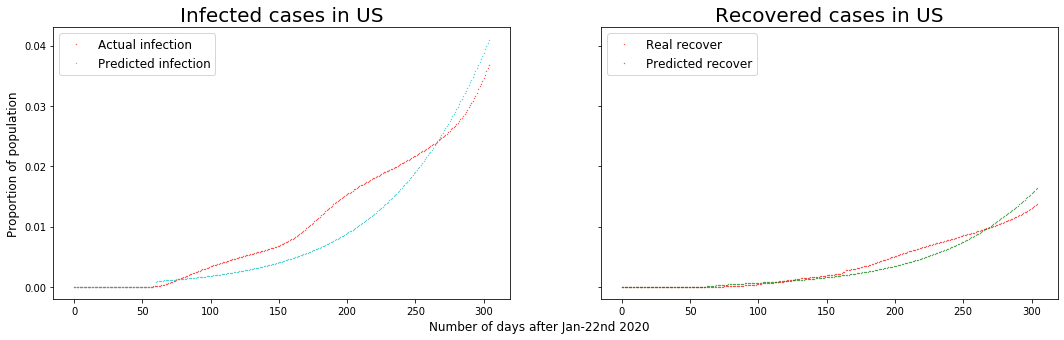

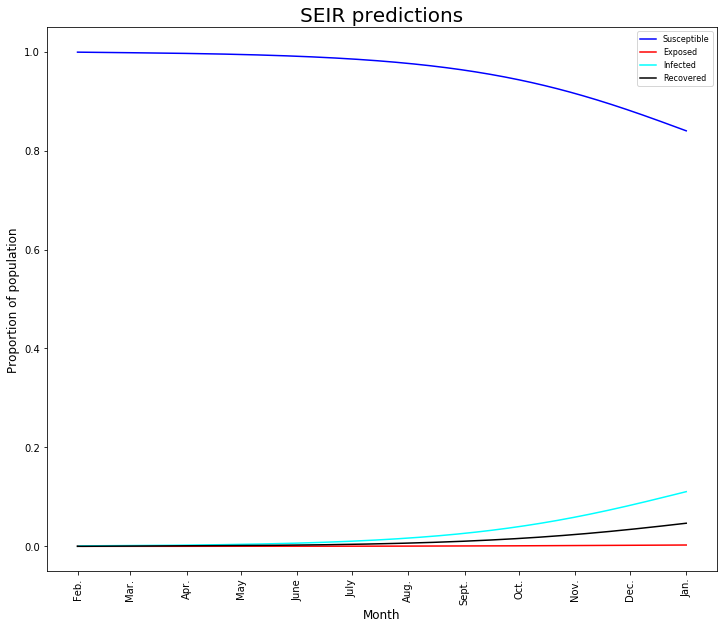

In [34]:
countryLockdown(328*1e6,us_status,58,'US');

# Italy

/Applications/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


## Italy before lockdown
Optimized infection rate:  0.11519613881642579
Optimized recovered rate:  -0.1110567916350988
Optimized exposed rate:  0.12650649760742302
Optimized reinfection rate:  3.4394672756608924


## Italy after lockdown
Optimize infection rate:  0.18386619142288135
Optimize recovered rate:  0.023605566661518817
Optimize exposed rate:  0.030278368432333412
Optimized reinfection rate:  0.0351290506830791


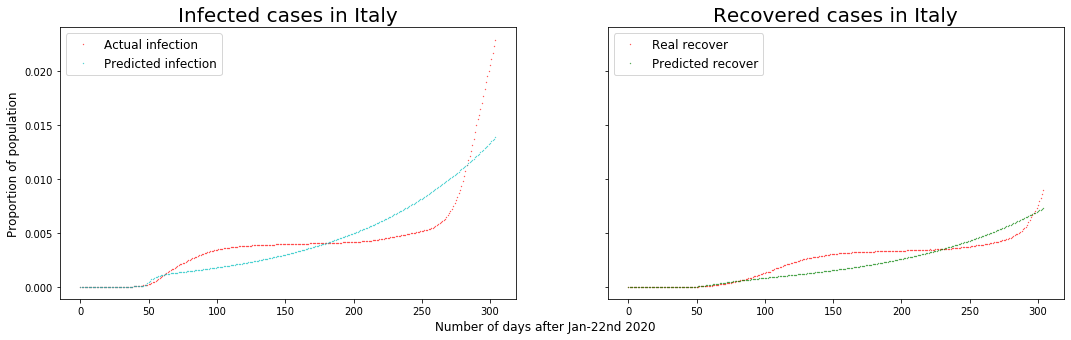

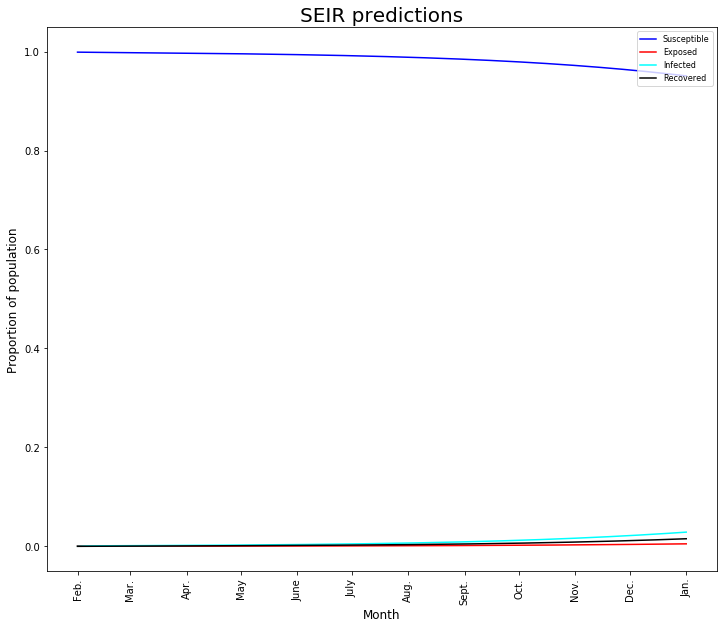

In [30]:
countryLockdown(60.36*1e6, itl_status,47,'Italy')

# France

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in double_scalars
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars


## France before lockdown
Optimized infection rate:  0.038397982067863594
Optimized recovered rate:  -0.07454114181926816
Optimized exposed rate:  0.1253822992668667
Optimized reinfection rate:  1.3714263853357673


## France after lockdown
Optimize infection rate:  0.0036149461405507012
Optimize recovered rate:  0.0025294628990104426
Optimize exposed rate:  0.02410300218854564
Optimized reinfection rate:  0.003109475958134079


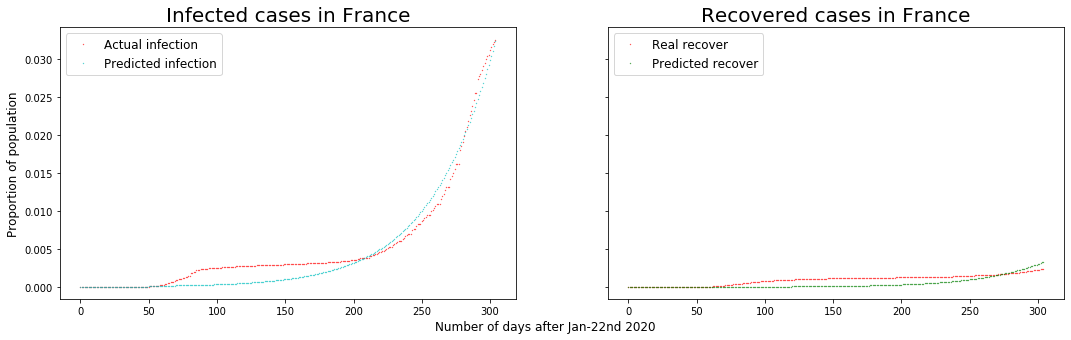

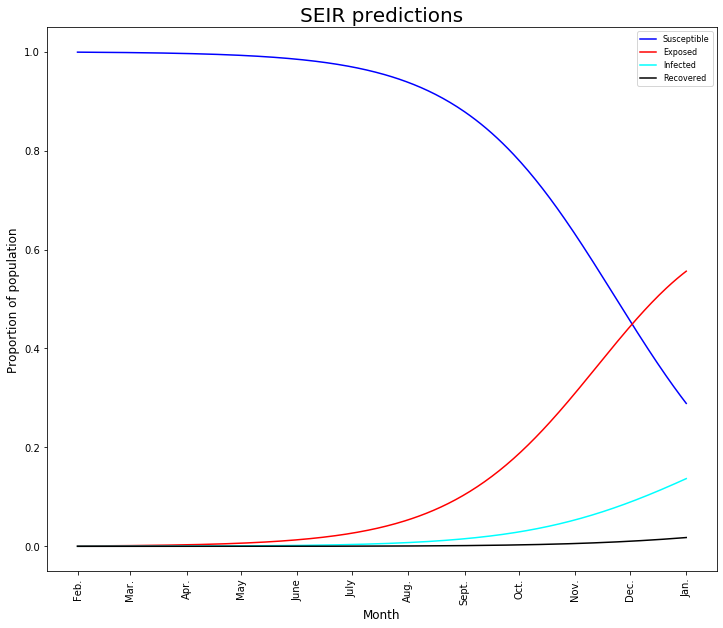

In [31]:
countryLockdown(66.99*1e6,frc_status,55,'France');

<a id="conclusion"></a>
## Conclusion
This model fits well with the current data in US, Italy and France. 
As COVID-19 continues to spread across the country and the world, we should remain calm and take actions to slow down its spreading.
